In [3]:
from IPython.core.display import HTML
HTML("<style>.container { width: 98% }<\style>")

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
activities_train = pd.read_csv('../data/act_train.csv.zip', index_col='activity_id', parse_dates=['date'])
activities_test = pd.read_csv('../data/act_test.csv.zip', index_col='activity_id', parse_dates=['date'])
people = pd.read_csv('../data/people.csv.zip', parse_dates=['date'])

In [4]:
activities_train.head()

,people_id,date,activity_category,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,outcome
activity_id,,,,,,,,,,,,,,
act2_1734928,ppl_100,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
act2_2434093,ppl_100,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
act2_3404049,ppl_100,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
act2_3651215,ppl_100,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
act2_4109017,ppl_100,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [5]:
people.head()

,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,char_8,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
people_id,,,,,,,,,,,,,,,,,,,,,
ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,type 2,...,False,True,True,False,False,True,True,True,False,36
ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,type 2,...,False,True,True,True,True,True,True,True,False,76
ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,type 2,...,False,False,True,True,True,True,False,True,True,99
ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,type 2,...,True,True,True,True,True,True,True,True,True,76
ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,type 2,...,False,False,True,False,False,False,True,True,False,84


In [6]:
activities_train.index.str.slice(0, 4).value_counts()

act2    2039676
act1     157615
Name: activity_id, dtype: int64

In [7]:
activities_train['index_prefix'] = activities_train.index.str.slice(0, 4)

In [8]:
activities_train.groupby('index_prefix')['activity_category'].value_counts()

index_prefix  activity_category
act1          type 1               157615
act2          type 2               904683
              type 5               490710
              type 3               429408
              type 4               207465
              type 6                 4253
              type 7                 3157
Name: activity_category, dtype: int64

#### => type 1 activities associated only with act1 ids.

In [9]:
activities_train['index_suffix'] = activities_train.index.str.slice(start=5).astype(float).astype(int)

In [10]:
activities_train.outcome.value_counts()

0    1221794
1     975497
Name: outcome, dtype: int64

#### => Slightly unbalanced data set

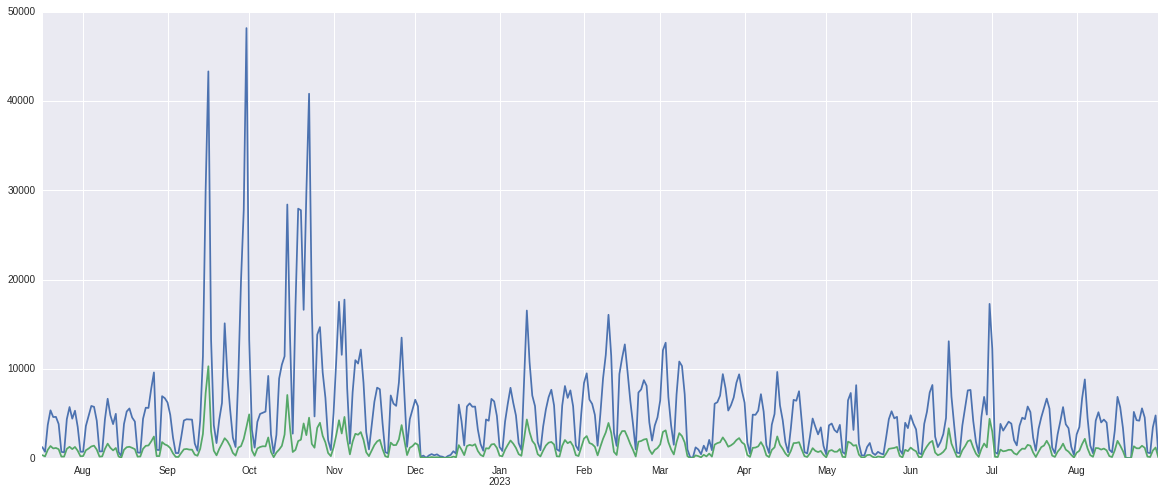

In [10]:
ax = activities_train.date.value_counts().sort_index().plot(figsize=(20, 8))
activities_test.date.value_counts().sort_index().plot(figsize=(20, 8), ax=ax)

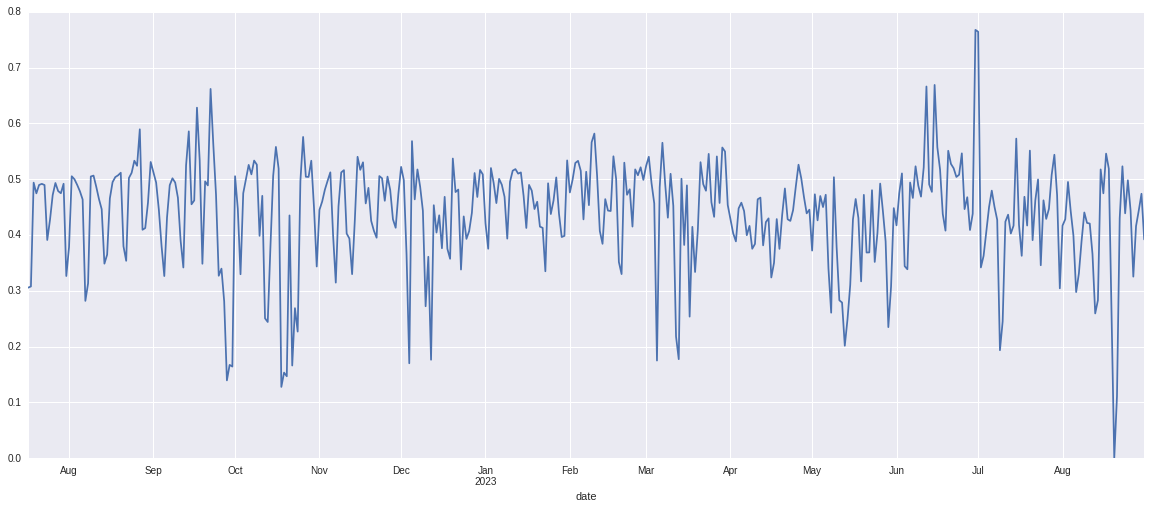

In [9]:
activities_train.groupby('date')['outcome'].mean().plot(figsize=(20, 8))

In [22]:
activities_train['day_of_week'] = activities_train.date.map(lambda x: x.dayofweek)
activities_test['day_of_week'] = activities_test.date.map(lambda x: x.dayofweek)

In [44]:
people['day_of_week'] = people.date.map(lambda x: x.dayofweek)

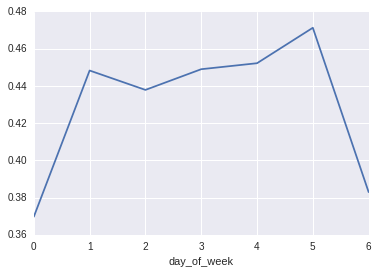

In [18]:
activities_train.groupby('day_of_week')['outcome'].mean().plot()

In [42]:
from sklearn.cross_validation import StratifiedKFold

train = activities_train['day_of_week']
test = activities_test['day_of_week']

targets = activities_train['outcome']
predictions = pd.Series(np.zeros_like(train), index=train.index, name='outcome')

cv_object = StratifiedKFold(y=targets, n_folds=4)

for train_index, test_index in cv_object:
    estimations = targets.iloc[train_index].groupby(train.iloc[train_index]).mean()
    predictions.iloc[test_index] = train.iloc[test_index].map(estimations)

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(targets, predictions)

0.50549472216032409

#### => Day of week of activities isn't good way to predict successful outcome

In [53]:
from sklearn.cross_validation import StratifiedKFold

train = pd.merge(activities_train[['people_id']], 
                 people[['people_id', 'day_of_week']], 
                 on='people_id', 
                 right_index=True).drop('people_id', axis=1).squeeze()

test = pd.merge(activities_test[['people_id']], 
                 people[['people_id', 'day_of_week']], 
                 on='people_id', 
                 right_index=True).drop('people_id', axis=1).squeeze()

targets = activities_train['outcome']
predictions = pd.Series(np.zeros_like(train), index=train.index, name='outcome')

cv_object = StratifiedKFold(y=targets, n_folds=4)

for train_index, test_index in cv_object:
    estimations = targets.iloc[train_index].groupby(train.iloc[train_index]).mean()
    predictions.iloc[test_index] = train.iloc[test_index].map(estimations)

In [54]:
from sklearn.metrics import roc_auc_score
roc_auc_score(targets, predictions)

0.52810196478373594

In [58]:
def encode_cat_feature_using_targets(feature_train, targets, feature_test, use_loo=False, alpha=1.0):
    # Compute smoothed mean of targets for each category in feature_train
    target_means = targets.groupby(feature_train).mean()
    
    # Map smoothed means on feature_test
    feature_test = feature_test.map(lambda x: target_means.get(x, default=0.5))
    
    if use_loo:
        category_lens = targets.groupby(feature_train).transform(len)
        feature_test = (category_lens * feature_test - targets + 1) / (category_lens + 1)
    return feature_test

In [55]:
people_cat_columns_to_use = ['people_id', 'group_1', 'char_2']
people_num_columns_to_use = [] #['char_38']

people_columns_to_use = people_cat_columns_to_use + people_num_columns_to_use

activities_cat_columns_to_use = ['people_id']

activities_columns_to_use = activities_cat_columns_to_use

cat_columns_to_use = set(people_cat_columns_to_use + activities_columns_to_use)
num_columns_to_use = people_num_columns_to_use

target_column = 'outcome'

In [56]:
train = pd.merge(people[people_columns_to_use], 
                 activities_train[activities_columns_to_use], 
                 on='people_id', 
                 left_index=True).drop('people_id', axis=1)

test = pd.merge(people[people_columns_to_use], 
                activities_test[activities_columns_to_use], 
                on='people_id', 
                left_index=True).drop('people_id', axis=1)

targets = activities_train[target_column]

In [59]:
for col in train.columns:
    if col in cat_columns_to_use:
        test[col] = encode_cat_feature_using_targets(train[col], targets, test[col], use_loo=False)
        train[col] = encode_cat_feature_using_targets(train[col], targets, train[col], use_loo=True)

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train[num_columns_to_use] = scaler.fit_transform(train[num_columns_to_use])
test[num_columns_to_use] = scaler.transform(test[num_columns_to_use])

In [60]:
train = train.astype(np.float32)
test = test.astype(np.float32)

In [61]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

Cs = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
log_regression = LogisticRegressionCV(Cs=Cs, scoring='roc_auc', cv=4, n_jobs=-1, verbose=2, random_state=45)

In [62]:
log_regression.fit(train, targets)

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   43.7s finished


LogisticRegressionCV(Cs=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
           class_weight=None, cv=4, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=45, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=2)

In [63]:
log_regression.scores_[1].mean(axis=0).max(), Cs[log_regression.scores_[1].mean(axis=0).argmax()]

(0.99662436971393209, 0.001)

In [84]:
predictions = pd.Series(log_regression.predict_proba(test)[:, 1], index=test.index, name='outcome')
predictions.to_csv('../submissions/first_log_regression.csv', index=True, header=True)